In [1]:
import os.path
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import itertools
import seaborn as sns

from scipy import interpolate
from matplotlib import pyplot as plt

(1000, 2)


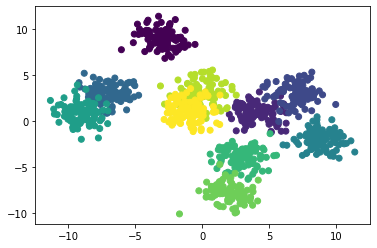

In [2]:
load=True
num_cells = 1000
num_dims_reduced = 2
num_branches = 2
K = 10 # cluster labels
if num_branches == 2:
    filename = 'fakedata-2branch.npy'
    start_node = 5
else:
    filename = 'fakedata-1branch.npy'
    start_node = 4

if load:
    data = np.load(filename, allow_pickle=True).item()
    cluster_labels = data['cluster_labels']
    data = data['data'].numpy()
else:
    cluster_labels = np.zeros([num_cells], dtype=int)
    data = list()
    for k in range(K):
        cells = num_cells // K
        offset = torch.randint(20, torch.Size([2])) - 10
        print(offset.shape)

        data.append(offset + torch.randn(torch.Size([num_cells//K, num_dims_reduced])))
        cluster_labels[k*cells:(k+1)*cells] = k
    data = torch.cat(data)
    np.save(filename, dict(data=data, cluster_labels=cluster_labels))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)

cluster_labels_onehot = np.zeros((cluster_labels.shape[0], cluster_labels.max()+1))
cluster_labels_onehot[np.arange(cluster_labels.shape[0]), cluster_labels] = 1

print(data.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

Lineages: [Lineage[5, 3, 9, 8, 0], Lineage[5, 3, 9, 8, 1, 2, 4], Lineage[5, 3, 9, 8, 1, 6, 7]]
iter
[1.79195524e+01 1.79195524e+01 1.79195524e+01 1.76910184e+01
 1.66571659e+01 1.79195524e+01 1.78640534e+01 1.79195524e+01
 1.62447436e+01 1.79195524e+01 1.64019123e+01 1.79195524e+01
 1.77057866e+01 1.79195524e+01 1.79195524e+01 1.79195524e+01
 1.73643531e+01 1.79195524e+01 1.61042106e+01 1.79195524e+01
 1.79195524e+01 1.62351044e+01 1.65837867e+01 1.69355154e+01
 1.79195524e+01 1.74601822e+01 1.79195524e+01 1.62824688e+01
 1.79195524e+01 1.74908536e+01 1.79195524e+01 1.69440029e+01
 1.79195524e+01 1.67637530e+01 1.79195524e+01 1.79195524e+01
 1.79195524e+01 1.79195524e+01 1.58523433e+01 1.76093478e+01
 1.77748039e+01 1.79195524e+01 1.79195524e+01 1.76606015e+01
 1.61028967e+01 1.79195524e+01 1.72840202e+01 1.76586554e+01
 1.79195524e+01 1.79195524e+01 1.79195524e+01 1.78606584e+01
 1.79195524e+01 1.79195524e+01 1.79195524e+01 1.74721191e+01
 1.79195524e+01 1.74248044e+01 1.73436107e+01 

 20%|██        | 1/5 [00:01<00:05,  1.26s/it]

[1.12944298e+01 1.12944298e+01 4.40436706e+00 1.12944298e+01
 1.12944298e+01 3.32531313e+00 1.12944298e+01 3.63472127e+00
 1.12944298e+01 1.12944298e+01 1.12944298e+01 2.98758019e+00
 1.12944298e+01 1.12944298e+01 1.12944298e+01 3.59577916e+00
 1.12944298e+01 1.12944298e+01 1.12944298e+01 4.12439467e+00
 2.84860518e+00 1.12944298e+01 1.12944298e+01 1.12944298e+01
 1.12944298e+01 1.12944298e+01 1.12944298e+01 1.12944298e+01
 1.12944298e+01 1.12944298e+01 1.12944298e+01 1.12944298e+01
 1.12944298e+01 4.97162279e+00 3.83135788e+00 3.53165606e+00
 1.12944298e+01 1.12944298e+01 1.12944298e+01 1.12944298e+01
 1.12944298e+01 3.29095763e+00 1.12944298e+01 4.57038829e+00
 1.12944298e+01 1.12944298e+01 4.32587068e+00 1.12944298e+01
 1.12944298e+01 3.00085413e+00 1.12944298e+01 1.12944298e+01
 1.12944298e+01 3.46285193e+00 1.12944298e+01 1.12944298e+01
 1.12944298e+01 1.12944298e+01 1.12944298e+01 1.12944298e+01
 1.12944298e+01 1.12944298e+01 4.25127343e+00 1.12944298e+01
 1.12944298e+01 1.129442

 40%|████      | 2/5 [00:02<00:03,  1.28s/it]

[1.12883218e+01 1.12883218e+01 4.40153354e+00 1.12883218e+01
 1.12883218e+01 3.32247376e+00 1.12883218e+01 3.63188471e+00
 1.12883218e+01 1.12883218e+01 1.12883218e+01 2.98518593e+00
 1.12883218e+01 1.12883218e+01 1.12883218e+01 3.59293644e+00
 1.12883218e+01 1.12883218e+01 1.12883218e+01 4.12155389e+00
 2.84800198e+00 1.12883218e+01 1.12883218e+01 1.12883218e+01
 1.12883218e+01 1.12883218e+01 1.12883218e+01 1.12883218e+01
 1.12883218e+01 1.12883218e+01 1.12883218e+01 1.12883218e+01
 1.12883218e+01 4.96878205e+00 3.82851954e+00 3.52881534e+00
 1.12883218e+01 1.12883218e+01 1.12883218e+01 1.12883218e+01
 1.12883218e+01 3.28811741e+00 1.12883218e+01 4.56754759e+00
 1.12883218e+01 1.12883218e+01 4.32303157e+00 1.12883218e+01
 1.12883218e+01 2.99801433e+00 1.12883218e+01 1.12883218e+01
 1.12883218e+01 3.46001134e+00 1.12883218e+01 1.12883218e+01
 1.12883218e+01 1.12883218e+01 1.12883218e+01 1.12883218e+01
 1.12883218e+01 1.12883218e+01 4.24843844e+00 1.12883218e+01
 1.12883218e+01 1.128832

 60%|██████    | 3/5 [00:03<00:02,  1.25s/it]

[1.12840021e+01 1.12840021e+01 4.39889453e+00 1.12840021e+01
 1.12840021e+01 3.31983133e+00 1.12840021e+01 3.62924219e+00
 1.12840021e+01 1.12840021e+01 1.12840021e+01 2.98399761e+00
 1.12840021e+01 1.12840021e+01 1.12840021e+01 3.59029174e+00
 1.12840021e+01 1.12840021e+01 1.12840021e+01 4.11891044e+00
 2.88237363e+00 1.12840021e+01 1.12840021e+01 1.12840021e+01
 1.12840021e+01 1.12840021e+01 1.12840021e+01 1.12840021e+01
 1.12840021e+01 1.12840021e+01 1.12840021e+01 1.12840021e+01
 1.12840021e+01 4.96613859e+00 3.82587787e+00 3.52617188e+00
 1.12840021e+01 1.12840021e+01 1.12840021e+01 1.12840021e+01
 1.12840021e+01 3.28547457e+00 1.12840021e+01 4.56490395e+00
 1.12840021e+01 1.12840021e+01 4.32038740e+00 1.12840021e+01
 1.12840021e+01 2.99622418e+00 1.12840021e+01 1.12840021e+01
 1.12840021e+01 3.45736798e+00 1.12840021e+01 1.12840021e+01
 1.12840021e+01 1.12840021e+01 1.12840021e+01 1.12840021e+01
 1.12840021e+01 1.12840021e+01 4.24579859e+00 1.12840021e+01
 1.12840021e+01 1.128400

 80%|████████  | 4/5 [00:05<00:01,  1.24s/it]

[1.12801444e+01 1.12801444e+01 4.39753623e+00 1.12801444e+01
 1.12801444e+01 3.31847286e+00 1.12801444e+01 3.62788287e+00
 1.12801444e+01 1.12801444e+01 1.12801444e+01 2.98543893e+00
 1.12801444e+01 1.12801444e+01 1.12801444e+01 3.58893088e+00
 1.12801444e+01 1.12801444e+01 1.12801444e+01 4.11755094e+00
 2.87985179e+00 1.12801444e+01 1.12801444e+01 1.12801444e+01
 1.12801444e+01 1.12801444e+01 1.12801444e+01 1.12801444e+01
 1.12801444e+01 1.12801444e+01 1.12801444e+01 1.12801444e+01
 1.12801444e+01 4.96477907e+00 3.82451926e+00 3.52481233e+00
 1.12801444e+01 1.12801444e+01 1.12801444e+01 1.12801444e+01
 1.12801444e+01 3.28411497e+00 1.12801444e+01 4.56354425e+00
 1.12801444e+01 1.12801444e+01 4.31902680e+00 1.12801444e+01
 1.12801444e+01 2.99740838e+00 1.12801444e+01 1.12801444e+01
 1.12801444e+01 3.45600841e+00 1.12801444e+01 1.12801444e+01
 1.12801444e+01 1.12801444e+01 1.12801444e+01 1.12801444e+01
 1.12801444e+01 1.12801444e+01 4.24444104e+00 1.12801444e+01
 1.12801444e+01 1.128014

100%|██████████| 5/5 [00:06<00:00,  1.25s/it]

[1.12783655e+01 1.12783655e+01 4.39646148e+00 1.12783655e+01
 1.12783655e+01 3.31739568e+00 1.12783655e+01 3.62680517e+00
 1.12783655e+01 1.12783655e+01 1.12783655e+01 2.98484993e+00
 1.12783655e+01 1.12783655e+01 1.12783655e+01 3.58785301e+00
 1.12783655e+01 1.12783655e+01 1.12783655e+01 4.11647328e+00
 2.87947516e+00 1.12783656e+01 1.12783655e+01 1.12783655e+01
 1.12783655e+01 1.12783655e+01 1.12783655e+01 1.12783655e+01
 1.12783655e+01 1.12783655e+01 1.12783655e+01 1.12783655e+01
 1.12783655e+01 4.96370136e+00 3.82344267e+00 3.52373462e+00
 1.12783655e+01 1.12783655e+01 1.12783655e+01 1.12783655e+01
 1.12783655e+01 3.28303777e+00 1.12783655e+01 4.56246663e+00
 1.12783655e+01 1.12783655e+01 4.31794866e+00 1.12783655e+01
 1.12783655e+01 2.99861243e+00 1.12783655e+01 1.12783655e+01
 1.12783655e+01 3.45493070e+00 1.12783655e+01 1.12783655e+01
 1.12783655e+01 1.12783655e+01 1.12783655e+01 1.12783655e+01
 1.12783655e+01 1.12783655e+01 4.24336451e+00 1.12783655e+01
 1.12783655e+01 1.127836

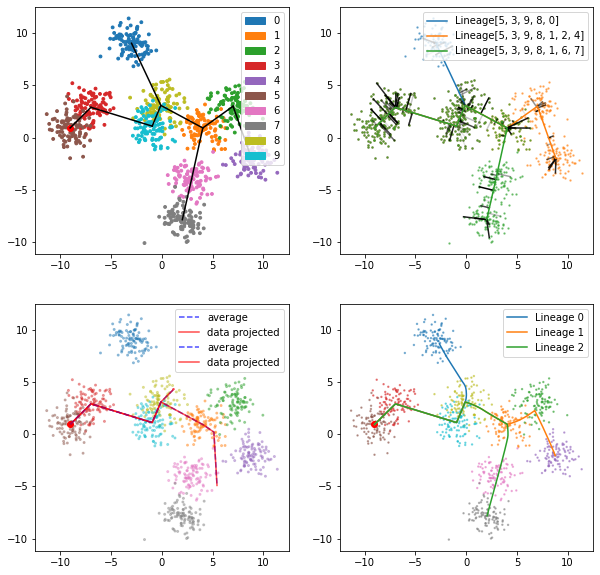

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

from slingshot import Slingshot

slingshot = Slingshot(data, cluster_labels_onehot, start_node=start_node, debug_level='verbose')

slingshot.fit(num_epochs=5, debug_axes=axes)

In [ ]:
tttttt


In [ ]:
def scipy_interpolate():
    x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
    y = np.sin(x)

    tck = interpolate.splrep(x, y, s=0.5)
    xnew = np.arange(0, 2*np.pi, np.pi/50)

    ynew = interpolate.splev(xnew, tck, der=0)

    plt.plot(xnew, ynew)
    plt.plot(xnew, np.sin(xnew))


